In [1835]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [1865]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.u_p  = self.getVar("grid_u_p_xyzt")
        self.u_n  = self.getVar("grid_u_n_xyzt")
        
        
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_c_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyzt")
        self.qv_p = self.getVar("grid_tracers_p_xyzt")
        self.qv_n = self.getVar("grid_tracers_n_xyzt")
        
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        # self.factor4 = self.getVar("factor4_xyzt")


        self.convection = self.getVar("convection_xyzt")
        
        # self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        # self.Uzm   = np.nanmean(self.u, axis=3)
        # self.Vzm   = np.nanmean(self.v, axis=3)
        # self.THzm  = np.nanmean(self.theta, axis=3)
        # self.Pzm   = np.nanmean(self.p, axis=3)
        # self.Tzm   = np.nanmean(self.t, axis=3)
        
        # ### anamoly
        # self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        # self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        # self.THzmtm = np.nanmean(self.THzm, axis=0)
        # self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        # self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        # self.Vza     = np.zeros(self.u.shape)
        # self.Uza     = np.zeros(self.u.shape)
        # self.THETAza = np.zeros(self.u.shape)
        # self.Pza     = np.zeros(self.u.shape)
        # self.Tza     = np.zeros(self.t.shape)

        # for i in range(0,128):
        #     self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
        #     self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
        #     self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
        #     self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
        #     self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        # self.xx, self.yy = np.meshgrid(self.x,self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p_half[:,i+1,:,:] - self.p_half[:,i,:,:])
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p_half[:, 1,:,:] - self.p_half[:, 0,:,:])
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

(100, 20, 64, 128)
200
0
300
1
400
2
500
3
600
4
700
5
800
6
900
7
1000
8
(100, 64)


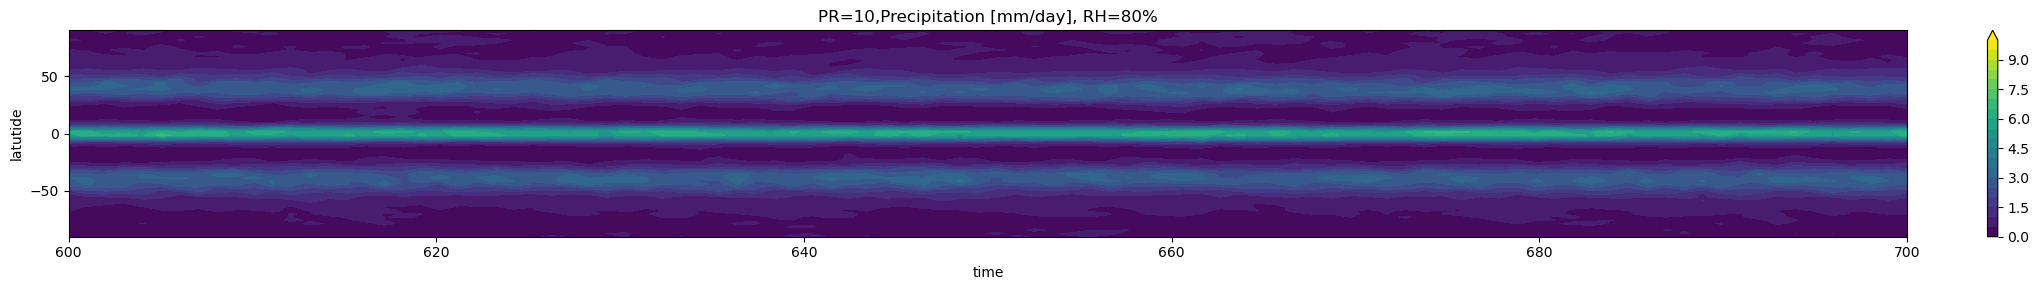

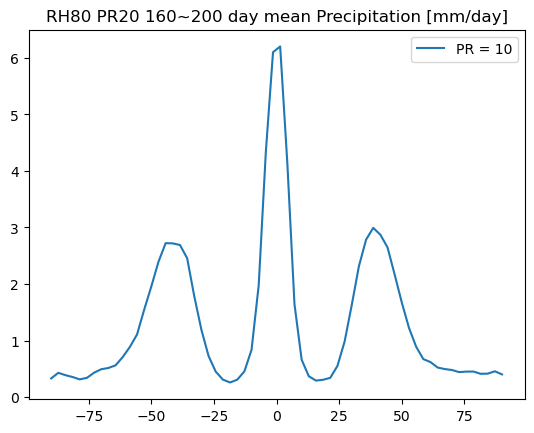

In [1942]:
# file = "HSt42_15/RH80_PR15_1000day_startfrom_300day_final.dat"
file  = "HSt42_20/RH80_PR20_1000day_startfrom_300day_final.dat"
file2 = "HSt42_20/RH80_PR20_1000day_startfrom_200day_final.dat"
file3 = "HSt42_20/RH80_PR20_1000day_startfrom_100day_final.dat"

file_list = r"HSt42_20/RH80_PR20_1000day_startfrom_[1-9]00day_final.dat"



# file = "HSt42_5/RH80_PR5_1000day_startfrom_100day_final.dat"

# file = "15day_test_final.dat"
# file = "5day_test_final.dat"
# dycore = Dycore(file)
dycore = Dycore(file)
dycore2 = Dycore(file2)
dycore3 = Dycore(file3)


# plt.close()
time = np.linspace(600,700,100)
y    = np.linspace(-90,90,64)

yy, tt = np.meshgrid(y,time)
a      = int(0)
fig    = plt.figure(figsize=(21,3))
u = dycore.u
print(u.shape)
a = 0
for pr in range(10,20,10):
    Prec = np.zeros(((9, 100, 64)))
    for day in range(200,1100,100):
        print(day)
    # file   = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    # file = "t_init_RH80_PR10_1600day_test_all.dat"
    # file = "test_final.dat"
        file  = f"HSt42_{pr}/RH80_PR{pr}_1000day_startfrom_{day}day_final.dat"
        dycore = Dycore(file)
        # dycore2 = Dycore(file2)
    
        # get_KE = dycore.cal_KE()   
        Prec[a,:,:]    = dycore.cal_pre()
        print(a)
        a+=1
    # Prec_stack = np.stack((Prec[0,:,:], Prec[1,:,:], Prec[2,:,:], Prec[3,:,:], Prec[4,:,:]), Prec[5,:,:])
    # print(np.shape(Prec_stack))
    
    Prec_new   = np.nanmean(Prec, axis=0)
    print(np.shape(Prec_new))
    

    # t_mean = dycore.cal_t()
    # t_mean2 = dycore.cal_t_last()
    
    
    # CS = plt.contourf(tt, yy, get_KE,levels=21, extend="both")
    
    CS = plt.contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,10,21), extend="max")
        
    # CS = plt.contourf(tt, yy, t_mean, levels=21, extend="both")
    
    
    plt.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04)
    # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
    plt.title(f"PR={pr},Precipitation [mm/day], RH=80%")
    # ax[a].set_title(f"T [K], PR={pr}")
    
    plt.xlabel("time")
    plt.ylabel("latutide")
    a += 1
    ### test
    
plt.tight_layout()
# plt.savefig("Without LH return precipitation.png", dpi=300., bbox_inches='tight')
plt.show()
###############################################################################
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)
xx, yy = np.meshgrid(x,y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
plt.title("RH80 PR20 160~200 day mean Precipitation [mm/day]")

for pr in range(10,20,10):
    # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    dycore = Dycore(file)
    Prec   = dycore.cal_pre()
    Prec_mean  = np.nanmean(Prec[:,:] * 86400 , axis=0)
    plt.plot(y, Prec_mean, label=f"PR = {pr}")
plt.legend()
plt.show()


3.5856691570724873e-07
0.0


Text(0.5, 1.0, 'Day160~200 file qv_diff')

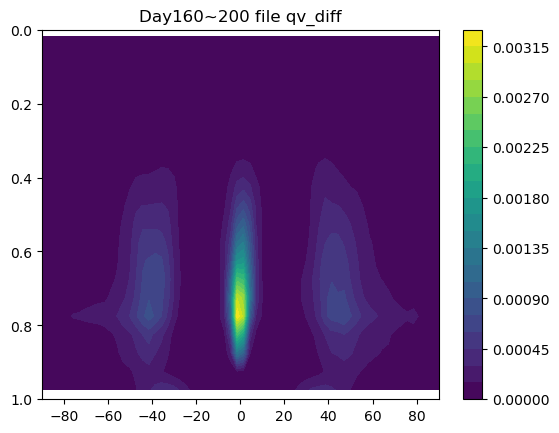

In [1838]:
qv_diff = dycore.qv_diff
print(np.nanmax(qv_diff))
print(np.nanmin(qv_diff))

qv_diff_mean = np.nanmean(qv_diff[-40:,:,:,:], axis=(0,3))
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_diff_mean*86400 , levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("Day160~200 file qv_diff")

Text(0.5, 1.0, 'Day150~200 file t')

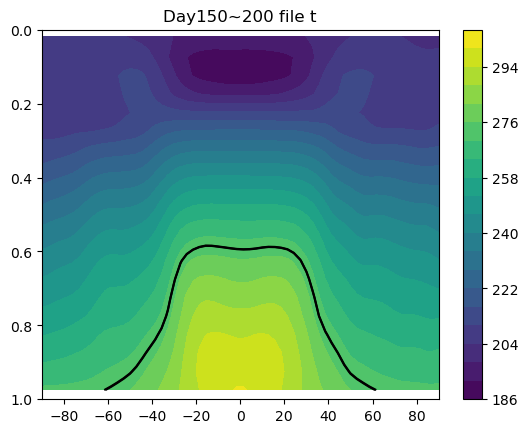

In [1839]:
qv_diff = dycore.t
qv_diff_mean = np.nanmean(qv_diff[-1:,:,:,:], axis=(0,3))
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_diff_mean, levels=21)
CS2 = plt.contour(yy,sigma_mean2, qv_diff_mean, [273,273.1], colors='k')

plt.colorbar(CS)
plt.ylim([1,0])
plt.title("Day150~200 file t")

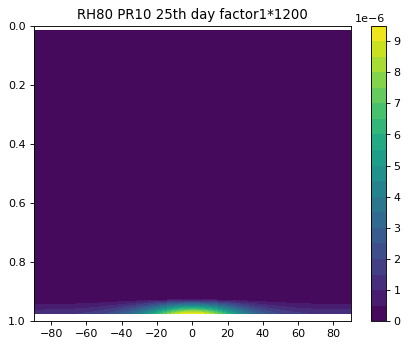

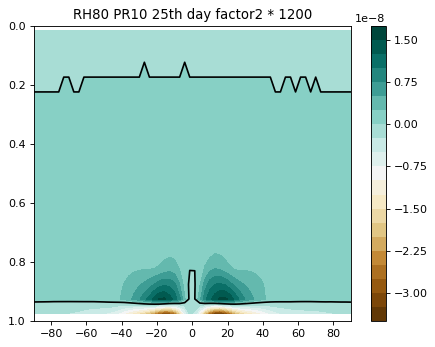

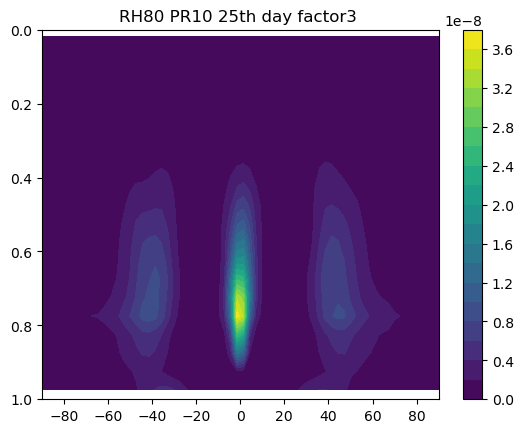

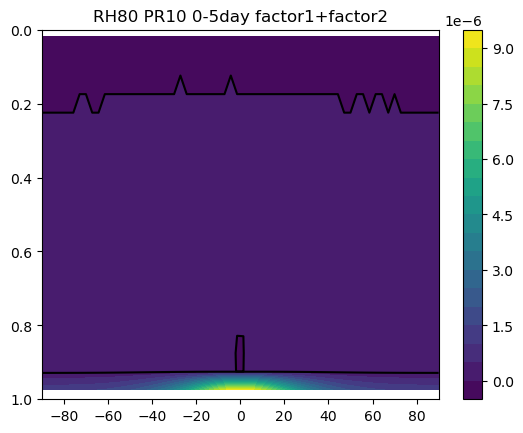

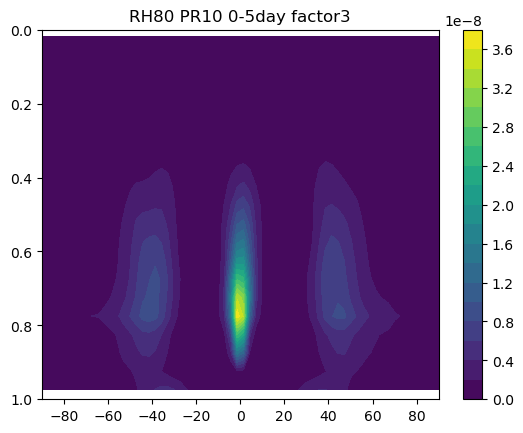

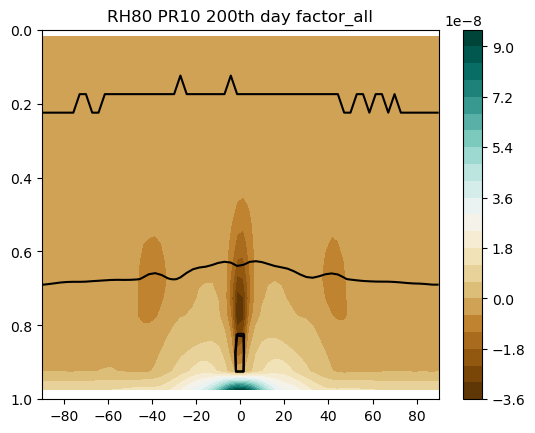

In [1840]:
day_ini = 0
day_final = -1

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor1 = dycore.factor1

    plt.figure(dpi=80.)
    factor1_mean = np.nanmean(factor1[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor1_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 25th day factor1*1200")

    plt.ylim([1,0])
    plt.show()
#############################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor2 = dycore.factor2

    plt.figure(dpi=80.)
    factor2_mean = np.nanmean(factor2[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor2_mean , levels=21, cmap="BrBG")
    plt.contour(yy, sigma_mean2, factor2_mean, [0,1E-7], colors='k')
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 25th day factor2 * 1200")

    plt.ylim([1,0])
    plt.show()
#################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor3 = dycore.factor3

    plt.figure(dpi=100.)
    factor3_mean = np.nanmean(factor3[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor3_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 25th day factor3 ")

    plt.ylim([1,0])
    plt.show()
###################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    plt.figure(dpi=100.)
    factor12_mean = np.nanmean(factor1[day_ini:day_final,:,:,:]+factor2[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor12_mean, levels=21)
    CS2 = plt.contour(yy, sigma_mean2, factor12_mean, [0,1E-7], colors='k')
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day factor1+factor2")

    plt.ylim([1,0])
    plt.show()
###################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor3 = dycore.getVar("factor3_xyzt")
    plt.figure(dpi=100.)
    factor3_mean = np.nanmean(factor3[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor3_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day factor3")

    plt.ylim([1,0])
    plt.show()
###################################################################
# for i in range(10,20,10):
#     pr = i
#     dycore = Dycore(file)
#     yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

#     factor4 = dycore.getVar("factor4_xyzt")
#     plt.figure(dpi=100.)
#     factor4_mean = np.nanmean(factor4[day_ini:day_final,:,:,:], axis=(0,3))

#     CS = plt.contourf(yy, sigma_mean2, factor4_mean, levels=21)
#     plt.colorbar(CS)
#     plt.title(f"RH80 PR{pr} 0-5day factor4")

#     plt.ylim([1,0])
#     plt.show()

###################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    plt.figure(dpi=100.)
    factor3 = dycore.getVar("factor3_xyzt")
    factor_mean = np.nanmean(factor1/100 + factor2 -factor3, axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor_mean, cmap="BrBG", levels=21) 
    CS2 = plt.contour(yy, sigma_mean2, factor12_mean, [0,1E-10], colors='k')
    
    # plt.contour(yy, sigma_mean2, factor_mean, [-0.0005,0], color='k')
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 200th day factor_all")

    plt.ylim([1,0])
    plt.show()



(20, 64)
(20, 64)


Text(0.5, 1.0, 'original file qv')

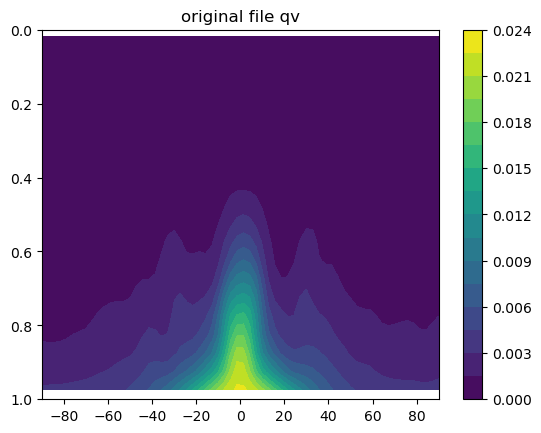

In [1841]:
qv = dycore.qv
qv_mean = np.nanmean(qv[-1:,:,:,:], axis=(0,3))
# xx, yy = dycore.xx, dycore.yy
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
print(np.shape(yy))
print(np.shape(sigma_mean2))

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_mean, levels=21) #np.linspace(0,0.00315,21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original file qv")


In [1842]:
plt.close()

In [1843]:
# dycore = Dycore(file)
# dycore = Dycore(file)
# plt.close()

In [1844]:
# file = "5_10day_test_warm_start_all.dat"
# time = np.linspace(5,10,5)
# y    = np.linspace(-90,90,64)

# yy, tt = np.meshgrid(y,time)
# a      = int(0)
# fig    = plt.figure(figsize=(21,3))
# for pr in range(10,20,10):
#     # file   = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
#     # file = "t_init_RH80_PR10_1600day_test_all.dat"
#     # file = "test_final.dat"
#     dycore_test = Dycore(file)
#     # get_KE = dycore.cal_KE()   
#     Prec   = dycore_test.cal_pre()

#     # t_mean = dycore.cal_t()
#     # t_mean2 = dycore.cal_t_last()
    
    
#     # CS = plt.contourf(tt, yy, get_KE,levels=21, extend="both")
    
#     CS = plt.contourf(tt, yy, Prec[:,:] * 86400,levels=np.linspace(0,2,21), extend="max")
        
#     # CS = plt.contourf(tt, yy, t_mean, levels=21, extend="both")
    
    
#     plt.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04)
#     # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
#     plt.title(f"PR={pr},Precipitation [mm/day], RH=80%")
#     # ax[a].set_title(f"T [K], PR={pr}")
    
#     plt.xlabel("time")
#     plt.ylabel("latutide")
#     a += 1
#     ### test
    
# plt.tight_layout()
# # plt.savefig("Without LH return precipitation.png", dpi=300., bbox_inches='tight')
# plt.show()
# ###############################################################################
# ### cooridate
# x  = np.linspace(-180,180,128)
# y  = np.linspace(-90,90,64)
# xd = np.deg2rad(x)
# yd = np.deg2rad(y)
# xx, yy = np.meshgrid(x,y)

# # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
# cy     = np.cos(yd)
# cy[0]  = np.nan
# cy[-1] = np.nan

# plt.figure(dpi=100.)
# plt.title("RH80 warm start last 5 day mean Precipitation [mm/day]")

# for pr in range(10,20,10):
#     # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     # file = f"PR{pr}_200day_test_ice_all.dat"
#     # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
#     dycore_test = Dycore(file)
#     Prec   = dycore_test.cal_pre()
#     Prec_mean  = np.nanmean(Prec[:,:] * 86400, axis=0)
#     plt.plot(y, Prec_mean * int(pr), label=f"PR = {pr}")
# plt.legend()
# plt.show()


In [1845]:
# qv_test = dycore_test.qv
# qv_test_mean = np.nanmean(qv_test[-1:,:,:,:], axis=(0,3))

In [1846]:
# # xx, yy = dycore.xx, dycore.yy
# yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
# print(np.shape(yy))
# print(np.shape(sigma_mean2))

# plt.figure()
# CS = plt.contourf(yy,sigma_mean2, qv_test_mean, levels=21)
# plt.colorbar(CS)
# plt.ylim([1,0])
# plt.title("test file qv")


In [1847]:
# qv_diff = dycore.qv_diff
# qv_diff_mean = np.nanmean(qv_diff[-5:,:,:,:], axis=(0,3))
# yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

# plt.figure()
# CS = plt.contourf(yy,sigma_mean2, qv_diff_mean, levels=21)
# plt.colorbar(CS)
# plt.ylim([1,0])
# plt.title("test warm start file qv_diff")


In [1848]:
plt.close()

In [1849]:
# file       = "0_10day_test_warm_start_all.dat"
# dycore     = Dycore(file)
# qv         = dycore.qv
# qv_mean    = np.nanmean(qv[-1,:,:,:], axis=(2))
# qv_mean_xy = np.nanmean(qv[-1,:,:,:], axis=(0))
# ###################################################
# file_test    = "5_10day_test_warm_start_all.dat"
# dycore_test  = Dycore(file_test)
# qv_test      = dycore_test.qv
# qv_test_mean = np.nanmean(qv_test[-1,:,:,:], axis=(2))
# qv_test_mean_xy = np.nanmean(qv_test[-1,:,:,:], axis=(0))

# plt.figure()
# CS = plt.contourf(yy,sigma_mean2, qv_test_mean - qv_mean, levels=21)
# plt.colorbar(CS)
# plt.ylim([1,0])
# plt.title("original qv - test qv")

In [1850]:
# x  = np.linspace(0,360,128)
# y2 = np.linspace(-90,90,64)
# xx,yy2 = np.meshgrid(x,y2)
# plt.figure()
# CS = plt.contourf(xx,yy2, qv_test_mean_xy - qv_mean_xy, levels=21)
# plt.colorbar(CS)
# # plt.ylim([1,0])
# plt.title("original qv - test qv")

In [1851]:
# plt.figure()
# CS = plt.contourf(xx,yy2, qv_mean_xy, levels=21)
# plt.colorbar(CS)
# # plt.ylim([1,0])
# plt.title("original qv")
# plt.figure()
# CS = plt.contourf(xx,yy2, qv_test_mean_xy, levels=21)
# plt.colorbar(CS)
# # plt.ylim([1,0])
# plt.title("test qv")

In [1852]:
# file       = "0_10day_test_warm_start_all.dat"
# dycore     = Dycore(file)
# qv         = dycore.qv_n
# qv_mean    = np.nanmean(qv[0+5,:,:,:], axis=(2))
# # qv_mean_xy = np.nanmean(qv[0,:,:,:], axis=(0)
# ###################################################
# file_test    = "0_10day_test_warm_start_all.dat"
# dycore_test  = Dycore(file_test)
# qv_n_test      = dycore_test.qv_n
# qv_test        = dycore_test.qv

# qv_test_mean = np.nanmean(qv_test[0,:,:,:], axis=(2))
# qv_n_test_mean = np.nanmean(qv_n_test[0,:,:,:], axis=(2))

# # qv_test_mean_xy = np.nanmean(qv_test[0,:,:,:], axis=(0))

# plt.figure()
# CS = plt.contourf(yy,sigma_mean2, qv_n_test_mean - qv_test_mean, levels=21)
# plt.colorbar(CS)
# plt.ylim([1,0])
# plt.title("original qv - test qv")


In [1853]:
plt.close()